# Sleep Analysis Algorithm

**Author:** Masoud Abedinifar

**Last update:** Fri 15 November 2024

#### References
[`1`] Louter, Maartje, et al. "Accelerometer-based quantitative analysis of axial nocturnal movements differentiates patients with Parkinson's disease, but not high-risk individuals, from controls." Journal of Neurology, Neurosurgery & Psychiatry 86.1 (2015): 32-37. https://doi.org/10.1136/jnnp-2013-306851

[`2`] Mirelman, Anat, et al. "Tossing and turning in bed: nocturnal movements in Parkinson's disease." Movement Disorders 35.6 (2020): 959-968. https://doi.org/10.1002/mds.28006

### Import Libraries

The necessary libraries, such as `numpy` and `pandas`, are imported.

In [ ]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import scipy.io

### Load data

- Please update file_path path to the data directory

In [ ]:
# Load the .mat file
file_path = r'\\...\COKI10147\T1\PROCESSED_NACHT\20190801_T1_COKI10147.mat'
mat_data = scipy.io.loadmat(file_path)

# Access the main data
data = mat_data['data']

# Iterate over all the data entries to find the 'SA' bodyLocation and 'accel' sensor name
for entry in data[0]:
    print("Checking entry:", entry['bodyLocation'][0])

    if entry['bodyLocation'][0] == 'SA':  # Lower back
        
        # Iterate over all sensors to find the accelerometer sensor
        for sensor in entry['sensorData'][0]:

            # Check if the sensor name is 'accel' (accelerometer)
            if sensor[0][0] == 'accel':

                # Directly extract the Fs value (128) from index 2, as it's stored in array([[128]])
                sampling_frequency = sensor[2][0][0]
                print("Sampling Frequency (Fs) for 'accel':", sampling_frequency)

                # Extract the accelerometer data from index 3
                accel_data = sensor[3] 
                print("Accelerometer Data (first 5 samples):", accel_data[:5])  

                # Extract the units of the accelerometer from index 4
                accel_unit = sensor[5][0][0]
                print("Raw Unit Information:", accel_unit)
                

Checking entry: FO
Checking entry: WR
Checking entry: SA
Sampling Frequency (Fs) for 'accel': 128
Accelerometer Data (first 5 samples): [[ 0.02497681 -0.02597192  1.00503514]
 [ 0.02692876 -0.02327802  1.00285899]
 [ 0.02595279 -0.02425762  1.00406796]
 [ 0.02644078 -0.02131882  1.00576053]
 [ 0.02619678 -0.02670662  1.00382617]]
Raw Unit Information: g


### Visualization of data

c:\Users\Project\AppData\Local\pypoetry\Cache\virtualenvs\kielmat-xtiGY1vY-py3.11\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


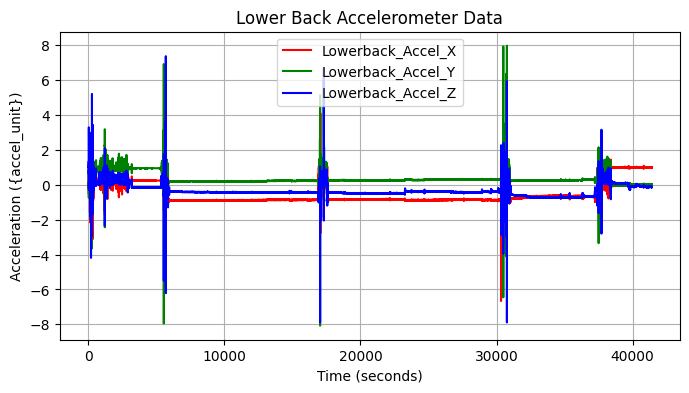

In [ ]:
# Create the time array
time = np.arange(0, len(accel_data)) / sampling_frequency

# Plot the accelerometer data for X, Y, Z axes
plt.figure(figsize=(8, 4))
plt.plot(time, accel_data[:, 0], label='Lowerback_Accel_X', color='r')
plt.plot(time, accel_data[:, 1], label='Lowerback_Accel_Y', color='g')
plt.plot(time, accel_data[:, 2], label='Lowerback_Accel_Z', color='b')

# Titles and labels
plt.title('Lower Back Accelerometer Data')
plt.xlabel('Time (seconds)')
plt.ylabel('Acceleration ({accel_unit})')
plt.legend()
plt.grid(True)
plt.show()

### Pre-process Acceleration Data:

- Apply a moving average filter to the accelerometer data with a window size of 10 seconds. 

In [ ]:
# Define the window size for the moving average filter (in seconds)
mov_avg_windows_size = 10

# Apply a moving average filter to the accelerometer data
filtered_accel_data = np.apply_along_axis(
    lambda x: np.convolve(
        x,  
        np.ones(int(mov_avg_windows_size * sampling_frequency)) / (mov_avg_windows_size * sampling_frequency),  
        mode='same'  
    ), 
    axis=0,  
    arr=accel_data  
)

# Convert the filtered accelerometer data into a pandas DataFrame
filtered_accel_data = pd.DataFrame(filtered_accel_data)

### Compute Mean Vertical Acceleration:

- •	Calculate the mean value of the vertical acceleration every 0.5 seconds over a 1-second window size.

In [ ]:
# Extract the vertical acceleration data (assuming the first column is the vertical axis)
accel_vertical = filtered_accel_data.iloc[:, 0].values 
accel_vertical_len = len(accel_vertical)

# Initialize an array to store the mean values of vertical acceleration
mean_val_vertical_accel = np.zeros(accel_vertical_len)

# Define the step size for moving the window (0.5 seconds)
step_size = 0.5 

# Loop through the vertical acceleration data in steps of 0.5 seconds
for i in range(0, accel_vertical_len, int(step_size * sampling_frequency)):
    end_index = i + int(sampling_frequency)  
    
    # If the end index goes beyond the length of the data, adjust it to the data length
    if end_index > accel_vertical_len:
        end_index = accel_vertical_len
    
    # Calculate the mean of the current 1-second window and store it in the mean_val array
    mean_val_vertical_accel[i:end_index] = np.mean(accel_vertical[i:end_index])

### Identify Lying and Standing Positions:

- Classify whether the participant is lying or standing based on the vertical acceleration signal based on defined value from reference [`2`].

In [7]:
# Define the threshold for identifying lying position based on reference number 2
threshold_lying_g = 0.4

# Initialize an array to store the identified lying positions (0 = not lying, 1 = lying)
lying_position = np.zeros(accel_vertical_len)

# Identify lying positions based on the mean vertical acceleration exceeding the lying threshold
lying_position[mean_val_vertical_accel > threshold_lying_g] = 1

### Detect Nocturnal Rest:

- Identify periods of lying for at least 5 minutes, which are considered as nocturnal rest based on defined value from reference [`2`].

In [8]:
# Define the minimum duration (in minutes) for a valid lying event
min_lying_duration_minute = 5

# Find the onset points where lying position changes (0 to 1 or 1 to 0)
lying_position_changes = np.where(np.diff(lying_position) != 0)[0] + 1

# Iterate through each onset point and filter out short-duration lying events
for i in range(len(lying_position_changes) - 1):
    if lying_position_changes[i + 1] - lying_position_changes[i] < (sampling_frequency * min_lying_duration_minute * 60):
        lying_position[lying_position_changes[i]:lying_position_changes[i + 1]] = lying_position[lying_position_changes[i] - 1]

# Updated lying positions represent the nocturnal rest periods
nocturnal_rest = lying_position 

### Calculate Angle of Lying Position:

- Determine the angle of the participant’s body during nocturnal rest to classify their lying posture.

In [ ]:
# Initialize the array to store the body angle (theta) in degrees
theta_body_angle = np.full(len(accel_vertical), np.nan)

# Iterate through each sample to calculate the body angle when the person is in the "nocturnal rest" position
for i in range(len(accel_vertical)):
    # Check if the current sample is part of the nocturnal rest period (lying position)
    if nocturnal_rest[i] == 1:
        # Calculate the body angle using the accelerometer data
        # The body angle (theta) is computed using the arctangent function of the Y and Z components
        theta_body_angle[i] = np.arctan2(accel_data[i, 1], accel_data[i, 2]) * 180 / np.pi  # Convert radians to degrees

### Filter the Angle of Lying Position to Remove Noise:

•	Apply a moving average filter to the angle of lying position using a 10-second window size.

In [10]:
# Apply a moving average filter to smooth the theta_body_angle values (body angle)
filtered_theta_body_angle = np.convolve(
    theta_body_angle,
    np.ones(int(mov_avg_windows_size * sampling_frequency)) / (mov_avg_windows_size * sampling_frequency), 
    mode='same'
)

### Classify the Lying Posture:

- Classify lying posture (back, right side, etc.) based on the filtered angle using pre-defined angle thresholds based from reference [`2`]:

    - From -45° to 45°: lying on the back
    - From 45° to 135°: lying on the right
    - From -45° to -135°: lying on the left
    - The rest: lying on the face

In [11]:
# Initialize an array to hold the lying posture values
# 0: No posture detected, 1: Lying on back, 2: Lying on right side, 3: Lying on left side, 4: Lying on belly
lying_posture = np.zeros_like(accel_vertical)

# Iterate over the entire accelerometer data to classify lying postures
for i in range(len(accel_vertical)):
    # Check if the current time index corresponds to a nocturnal rest period (nocturnal_rest = 1)
    if nocturnal_rest[i] == 1:
        # If the body angle is between -45° and 45°, the person is lying on their back
        if -45 <= filtered_theta_body_angle[i] <= 45:
            lying_posture[i] = 1

        # If the body angle is between 45° and 135°, the person is lying on their right side
        elif 45 < filtered_theta_body_angle[i] <= 135:
            lying_posture[i] = 2 

        # If the body angle is between -135° and -45°, the person is lying on their left side
        elif -135 <= filtered_theta_body_angle[i] < -45:
            lying_posture[i] = 3

        # If the body angle is outside the range of -135° to 135°, the person is lying on their belly
        else:
            lying_posture[i] = 4

### Detect Turning Movements During Nocturnal Rest:

- Identify turning movements during nocturnal rest.

In [12]:
# Initialize an array to flag turning movements
# 0: No turning, 1: Turning detected
turn_flag = np.zeros_like(accel_vertical)

# Identify turning movements by detecting changes in lying posture
# The change in posture indicates a potential turn, so we look for where the lying posture changes
# A non-zero difference (i.e., 1 or -1) indicates a change in posture, which might correspond to a turning movement
# Get indices where posture changes
turning_indices = np.where(np.diff(lying_posture) != 0)[0]

# Iterate over the turning indices to flag the actual turning events
for idx in turning_indices:
    turn_flag[idx] = 1  # Mark the point where the turn starts
    if idx + 1 < len(turn_flag):  # Mark the point where the turn ends (next change in posture)
        turn_flag[idx + 1] = 1

### Extract Turning Parameters:

- Extract key parameters for each turn (e.g., turn duration, angle, and velocity):

    - Turn onset: Time at which the turn starts (in seconds)
    - Turn angle: Total angular change during the turn (in degrees)
    - Turn velocity: Rate of change of the body angle (in degrees per second)

In [ ]:
# Calculate turning parameters:
turn_onsets = []
turn_angles = []
turn_velocities = []

# Loop through the turning events and calculate the parameters
for i in range(1, len(turning_indices)):
    start_idx = turning_indices[i - 1]
    end_idx = turning_indices[i]
    
    # Calculate turn onset
    turn_onset = start_idx / sampling_frequency
    turn_onsets.append(turn_onset)
    
    # Calculate turn angle
    angle_change = filtered_theta_body_angle[end_idx] - filtered_theta_body_angle[start_idx]
    turn_angles.append(angle_change)
    
    # Calculate turn velocity
    time_diff = (end_idx - start_idx) / sampling_frequency  
    if time_diff > 0:
        velocity = angle_change / time_diff 
    else:
        velocity = 0
    turn_velocities.append(velocity)

# Output extracted turning parameters
turn_parameters = pd.DataFrame({
    'Turn Onset (sec)': turn_onsets,
    'Turn Angle (deg)': turn_angles,
    'Turn Velocity (deg/sec)': turn_velocities
})

print(turn_parameters)

    Turn Onset (sec)  Turn Angle (deg)  Turn Velocity (deg/sec)
0       38382.992188               NaN                      NaN
1       38387.992188               NaN                      NaN
2       38391.531250         -0.065356                -0.000050
3       39705.195312         90.005069                20.354503
4       39709.617188          0.159118                 0.001344
..               ...               ...                      ...
94      40572.882812         90.034210                30.407332
95      40575.843750         90.020325                24.568447
96      40579.507812          0.225757                 0.044525
97      40584.578125         -0.220809                -0.016985
98      40597.578125          0.267131                 0.000334

[99 rows x 3 columns]
